# Creating Data Subsets

In [1]:
import cudf
import sys
import pandas as pd
import time

## Reading in Datasets

In [2]:
# Reading in the Carbon Dioxide Dataset
co_df = cudf.read_csv("1980-2008-CO.csv")
co_df["RAW_VALUE"] = co_df.RAW_VALUE.astype(float)
co_df["ROUNDED_VALUE"] = co_df.RAW_VALUE.astype(float)

In [3]:
# Reading in the CO station information
station_co_df = cudf.read_csv("bc_air_monitoring_stations.csv")

## Creating Tests

In [4]:
def mean(co_subset):
    # Computing the average raw value
    return co_subset['RAW_VALUE'].mean()

def sort(co_subset):
    # Sorting based on the raw CO value 
    return co_subset.sort_values(['RAW_VALUE'], ascending=True)

def merge(co_subset, station_co_df):
    # Merging with the CO Stations to find which station made each measurement
    return co_subset.merge(station_co_df, how='left', on='STATION_NAME')

def filters(co_subset):
    # Filtering to the "Victoria Topaz" station
    filterd_pan_df = co_subset[co_subset['STATION_NAME'] == 'Victoria Topaz']
    
def all_tests(co_subset, station_co_df):
    # Computing the average raw value
    pan_mean = co_subset['RAW_VALUE'].mean()

    # Sorting based on the raw CO value 
    pan_sort_df = co_subset.sort_values(['RAW_VALUE'], ascending=True)

    # Merging with the CO Stations to find which station made each measurement
    panmerge_df = co_subset.merge(station_co_df, how='left', on='STATION_NAME')

    # Filtering to the "Victoria Topaz" station
    filterd_pan_df = co_subset[co_subset['STATION_NAME'] == 'Victoria Topaz']
    
def tester(test, co_subset, station_co_df, NUM_EXECUTIONS_PER_TEST):    
    if test == 'mean':
        # Starting timer
        t0 = time.time()   

        for i in range(0,NUM_EXECUTIONS_PER_TEST):
            mean(co_subset)
            
        # Stopping clock
        t1 = time.time()

        # Recording Results
        total_time = t1-t0
        avg_time = total_time/NUM_EXECUTIONS_PER_TEST

        return total_time, avg_time
    
    elif test == 'sort':
        # Starting timer
        t0 = time.time()   

        for i in range(0,NUM_EXECUTIONS_PER_TEST):
            sort(co_subset)
            
        # Stopping clock
        t1 = time.time()

        # Recording Results
        total_time = t1-t0
        avg_time = total_time/NUM_EXECUTIONS_PER_TEST

        return total_time, avg_time
      
    elif test == 'merge':
        # Starting timer
        t0 = time.time()   

        for i in range(0,NUM_EXECUTIONS_PER_TEST):
            merge(co_subset, station_co_df)
            
        # Stopping clock
        t1 = time.time()

        # Recording Results
        total_time = t1-t0
        avg_time = total_time/NUM_EXECUTIONS_PER_TEST

        return total_time, avg_time
    elif test == 'filter':
        # Starting timer
        t0 = time.time()   

        for i in range(0,NUM_EXECUTIONS_PER_TEST):
            filters(co_subset)
            
        # Stopping clock
        t1 = time.time()

        # Recording Results
        total_time = t1-t0
        avg_time = total_time/NUM_EXECUTIONS_PER_TEST

        return total_time, avg_time
    else:
        # Starting timer
        t0 = time.time()   

        for i in range(0,NUM_EXECUTIONS_PER_TEST):
            all_tests(co_subset, station_co_df)
            
        # Stopping clock
        t1 = time.time()

        # Recording Results
        total_time = t1-t0
        avg_time = total_time/NUM_EXECUTIONS_PER_TEST

        return total_time, avg_time
        
          
    # Stopping clock
    t1 = time.time()
    
    # Recording Results
    total_time = t1-t0
    avg_time = total_time/NUM_EXECUTIONS_PER_TEST
    
    return total_time, avg_time
        

In [5]:
NUM_START_ROWS = 2500

NUM_EXECUTIONS_PER_TEST = 3

NUM_DSIZE_DOUBLINGS = 11
# NUM_DSIZE_DOUBLINGS = 3

## Executing Tests

### RAPIDS

In [6]:
numRows = NUM_START_ROWS

rapids = []
for i in range(0, NUM_DSIZE_DOUBLINGS):
    print('Test:', i)
    
    numRows = numRows * 2
    
    if numRows > len(co_df):
        co_subset = co_subset.append(co_subset)
    else:
        co_subset = co_df.iloc[0:numRows]
        
    # ******************************************************************************
    # MEAN TEST
    
    test = {'Test':'Mean'}
    total_time, avg_time = tester('mean', co_subset, station_co_df, NUM_EXECUTIONS_PER_TEST)
    test['Total'] = total_time
    test['Average'] = avg_time
    
    rapids.append(test)
    
    # ******************************************************************************
    
    # SORT TEST
    
    test = {'Test':'Sort'}
    
    total_time, avg_time = tester('sort', co_subset, station_co_df, NUM_EXECUTIONS_PER_TEST)
    
    test['Total'] = total_time
    test['Average'] = avg_time
    
    rapids.append(test)
    
    # ******************************************************************************
    
    # MERGE TEST
    
    test = {'Test':'Merge'}
    
    total_time, avg_time = tester('merge', co_subset, station_co_df, NUM_EXECUTIONS_PER_TEST)
    
    test['Total'] = total_time
    test['Average'] = avg_time
    
    rapids.append(test)
    
    # ******************************************************************************
    
    # FILTER TEST
    
    test = {'Test':'Filter'}
    
    total_time, avg_time = tester('filter', co_subset, station_co_df, NUM_EXECUTIONS_PER_TEST)
    
    test['Total'] = total_time
    test['Average'] = avg_time
        
    rapids.append(test)
    
    # ******************************************************************************
    
    # ALL TEST
    
    test = {'Test':'All'}
    
    total_time, avg_time = tester('all', co_subset, station_co_df, NUM_EXECUTIONS_PER_TEST)
    
    test['Total'] = total_time
    test['Average'] = avg_time
    
    rapids.append(test)
    
    # ******************************************************************************
    
results_df_rapids = pd.DataFrame(rapids)

Test: 0
Test: 1
Test: 2
Test: 3
Test: 4
Test: 5
Test: 6
Test: 7
Test: 8
Test: 9
Test: 10


### PANDAS

In [7]:
# Moving all DFs to CPU for pandas
co_df = co_df.to_pandas()
station_co_df = station_co_df.to_pandas()

In [8]:
numRows = NUM_START_ROWS

results = []

for i in range(0, NUM_DSIZE_DOUBLINGS):
    print('Test:', i)
    numRows = numRows * 2
    
    if numRows > len(co_df):
        co_subset = co_subset.append(co_subset)
    else:
        co_subset = co_df.iloc[0:numRows]
        
    dfSize_GB = sys.getsizeof(co_subset) * 10**(-9)
        
    # ******************************************************************************
    # MEAN TEST
    
    test = {'Test Size':dfSize_GB, 'Test':'Mean'}
    total_time, avg_time = tester('mean', co_subset, station_co_df, NUM_EXECUTIONS_PER_TEST)
    test['Total'] = total_time
    test['Average'] = avg_time
    
    results.append(test)
    
    # ******************************************************************************
    
    # SORT TEST
    
    test = {'Test Size':dfSize_GB, 'Test':'Sort'}
    
    total_time, avg_time = tester('sort', co_subset, station_co_df, NUM_EXECUTIONS_PER_TEST)
    
    test['Total'] = total_time
    test['Average'] = avg_time
    
    results.append(test)
    
    # ******************************************************************************
    
    # MERGE TEST
    
    test = {'Test Size':dfSize_GB, 'Test':'Merge'}
    
    total_time, avg_time = tester('merge', co_subset, station_co_df, NUM_EXECUTIONS_PER_TEST)
    
    test['Total'] = total_time
    test['Average'] = avg_time
    
    results.append(test)
    
    # ******************************************************************************
    
    # FILTER TEST
    
    test = {'Test Size':dfSize_GB, 'Test':'Filter'}
    
    total_time, avg_time = tester('filter', co_subset, station_co_df, NUM_EXECUTIONS_PER_TEST)
    
    test['Total'] = total_time
    test['Average'] = avg_time
        
    results.append(test)
    
    # ******************************************************************************
    
    # ALL TEST
    
    test = {'Test Size':dfSize_GB, 'Test':'All'}
    
    total_time, avg_time = tester('all', co_subset, station_co_df, NUM_EXECUTIONS_PER_TEST)
    
    test['Total'] = total_time
    test['Average'] = avg_time
    
    results.append(test)
    
    # ******************************************************************************
    
results_df_pandas = pd.DataFrame(results)

Test: 0
Test: 1
Test: 2
Test: 3
Test: 4
Test: 5
Test: 6
Test: 7
Test: 8
Test: 9
Test: 10


## Results

In [9]:
results_df = pd.concat( 
    [
        pd.concat({"Pandas": results_df_pandas}, axis=1), 
        pd.concat({"Rapids": results_df_rapids}, axis=1)
    ],
    axis=1
)
results_df.to_csv('pandas_v_rapids_results.csv')
results_df.head()

Pandas                              Rapids                    
  Test Size    Test     Total   Average    Test     Total   Average
0   0.00379    Mean  0.000274  0.000091    Mean  0.004482  0.001494
1   0.00379    Sort  0.002186  0.000729    Sort  0.028676  0.009559
2   0.00379   Merge  0.025727  0.008576   Merge  0.048513  0.016171
3   0.00379  Filter  0.002162  0.000721  Filter  0.016682  0.005561
4   0.00379     All  0.029296  0.009765     All  0.104480  0.034827

## Vizualization

In [10]:
import os
os.environ[ 'MPLCONFIGDIR' ] = '/tmp/'
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# Defining the plot that is used
def plot(axs, averages_pandas, averages_rapids, test):
    axs.bar(x = ind, 
            height=averages_pandas, 
            width = width, 
            color='royalblue', label='Pandas')

    axs.bar(ind+width, 
                height=averages_rapids, 
                width = width, 
                color='seagreen',label='Rapids')

    axs.set_ylabel('Average Time (s)')
    axs.set_xlabel('Data Set Size (GB)')
    axs.set_title(f"Test: {test}",fontweight="bold", fontsize=12)
    axs.legend(loc='upper right')
    axs.set_xticks(ticks=ind + width/2, 
              labels=bar_labels)
    return axs

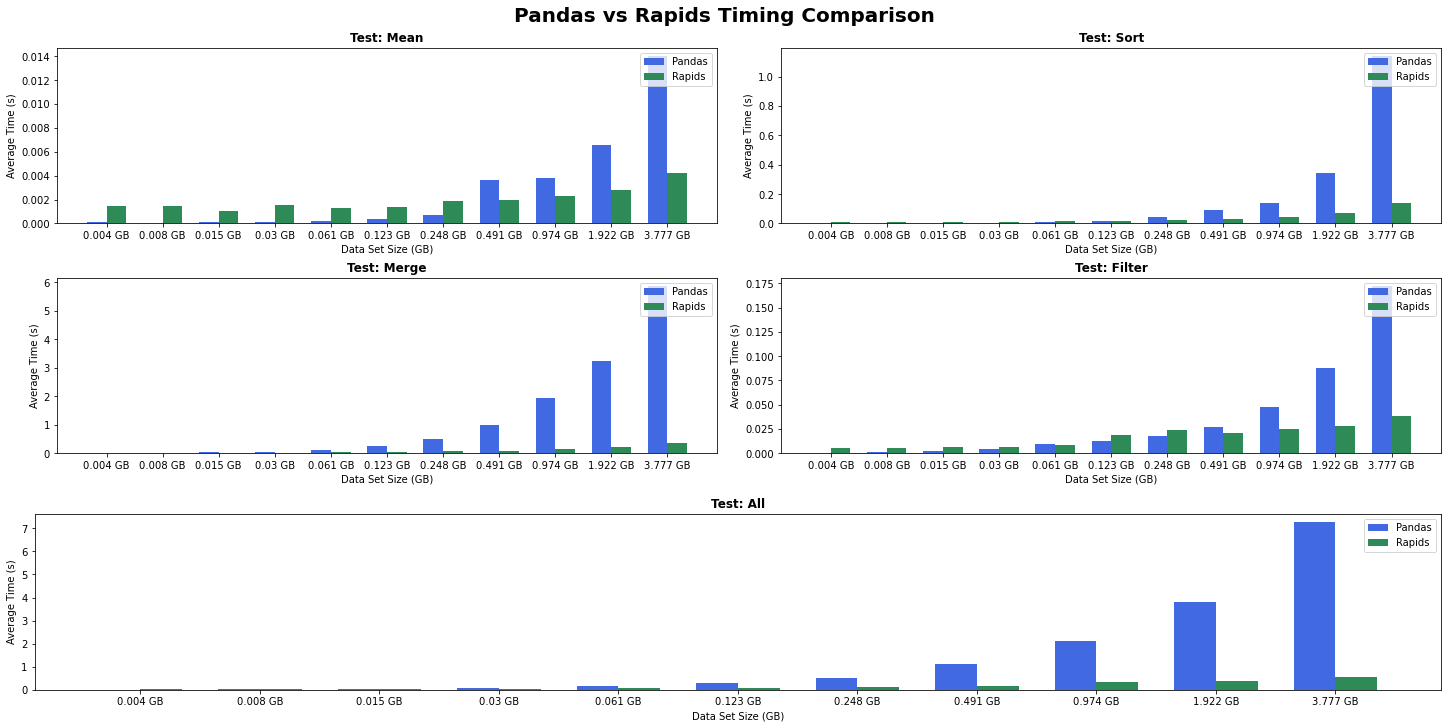

In [12]:
# Creating the plot matrix

# Computing an array to hold the test names
tests = np.append(results_df_pandas['Test'].drop_duplicates().values,'None').reshape((3,2))

# Defining the figure
fig = plt.figure(constrained_layout=True,figsize=(3,3))
fig.tight_layout(pad=5.0)

fig.suptitle('Pandas vs Rapids Timing Comparison', fontsize=20, fontweight="bold")

# Setting the fig size
fig.set_size_inches(20, 10)

# Creating the subfigures
subfigs = fig.subfigures(2, 1, wspace=1,height_ratios=[2, 1.])
axs = subfigs[0].subplots(2, 2)

# Setting the number of bars
ind = np.arange(NUM_DSIZE_DOUBLINGS)

# Defining the width between the bars
width = 0.35

# Defining the bar labels
bar_labels = np.round(results_df_pandas['Test Size'].drop_duplicates(), 3).astype(str) + " GB"

# Creating the plots
for i in range(0, 2):
    for j in range(0, 2):
        test = tests[i, j]            
        plot(axs[i,j], 
             results_df_pandas[results_df_pandas['Test'] == test]['Average'],
             results_df_rapids[results_df_rapids['Test'] == test]['Average'],
             test)
# Creating the bottom plot since there is an odd number
ax = subfigs[1].subplots(1,1)
plot(ax, 
     results_df_pandas[results_df_pandas['Test'] == 'All']['Average'],
     results_df_rapids[results_df_rapids['Test'] == 'All']['Average'],
     'All')
plt.savefig('pandas_v_rapids.png')